<a href="https://colab.research.google.com/github/cheneeheng/Transformer-TF/blob/colab_dev/Cifar10_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 Classification**

Based on [CIFAR10_Keras_GPU.ipynb](https://github.com/katnoria/cifar10-native-vs-colab/blob/master/CIFAR10_Keras_GPU.ipynb) from [katnoria/cifar10-native-vs-colab](https://github.com/katnoria/cifar10-native-vs-colab) .

General info about the dataset:
- 50K Train, 10K Test
- 10 object classes


# Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
tf.__version__

'2.4.1'

# Data generator

In [2]:
from tensorflow.keras.datasets import cifar10

(x_trn_full, y_trn_full), (x_tst, y_tst) = cifar10.load_data()

# remove the last dimension
y_trn_full = y_trn_full.reshape(y_trn_full.shape[0],)
y_tst = y_tst.reshape(y_tst.shape[0],)

# perform in model.
# # normalize data to 0..1
# x_trn_full, x_tst = x_trn_full / 255.0, x_tst / 255.0

# create validation split
# split = 0.2
# x_trn, x_val, y_trn, y_val = train_test_split(
#     x_trn_full, y_trn_full, test_size=split, random_state=1969)
x_trn, x_val, y_trn, y_val = x_trn_full, x_tst, y_trn_full, y_tst

print(f'x_trn.shape: {x_trn.shape}')
print(f'y_trn.shape: {y_trn.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'x_tst shape: {x_tst.shape}')
print(f'y_tst.shape: {y_tst.shape}')

x_trn.shape: (50000, 32, 32, 3)
y_trn.shape: (50000,)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000,)
x_tst shape: (10000, 32, 32, 3)
y_tst.shape: (10000,)


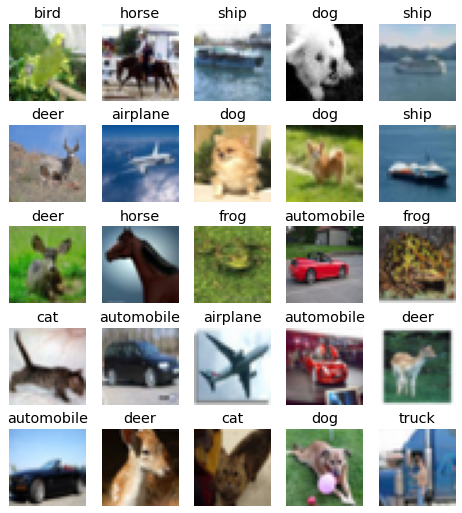

In [3]:
# pick 25 random images and plot
idxs = np.random.randint(x_trn.shape[0], size=25)
images = x_trn[idxs]
labels = y_trn[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
plt.show()

In [4]:
class Patches(tf.keras.layers.Layer):
  """Creates patches from an image. Implemented as a keras layer."""
  def __init__(self, patch_size: int):
    super().__init__()
    self.patch_size = patch_size

  def call(self, x):
    batch_size = tf.shape(x)[0]
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

  def get_config(self):
    return {"patch_size": self.patch_size}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


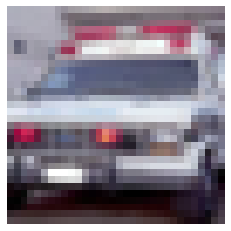

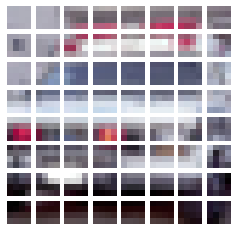

In [5]:
plt.figure(figsize=(4, 4))
image = x_trn[np.random.choice(range(x_trn.shape[0]))]
plt.imshow(image)
plt.axis("off")

image_size = 32
patch_size = 4

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [6]:
def data_generator(split: str, batch_size: int, shuffle_buffer: int = 10000):
  """Creates a tf.data.Dataset instance.

  Args:
      split: The type of data to generate, ['train', 'val', 'test'].
      batch_size: Batch size.
      shuffle_buffer: Number of elements used for shuffling.

  Returns:
      A tf.data.Dataset instance.

  Raises:
      ValueError: If `split` is not ['train', 'val', 'test'].

  """
  if split == 'train':
    ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
    ds = ds.shuffle(shuffle_buffer)
  elif split == 'val':
    ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  elif split == 'test':
    ds = tf.data.Dataset.from_tensor_slices((x_tst, y_tst))
  else:
    raise ValueError(f"Unknown data split : {split}")
  return ds.batch(batch_size)

# Model

A simple CNN example from the keras [CNN benchmark](https://github.com/keras-team/keras/blob/master/keras/benchmarks/keras_examples_benchmarks/cifar10_cnn_benchmark_test.py) .  
It is based on this [CNN example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) but the example is no longer available.


In [7]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Conv2D, 
  BatchNormalization, 
  MaxPool2D,
  Dropout,
  Flatten,
  Dense
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu
from tensorflow.keras.layers.experimental.preprocessing import (
  RandomFlip,
  RandomTranslation,
  RandomRotation,
  RandomZoom,
  Normalization,
  Resizing
)

def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
  return Conv2D(filters, 
                kernel_size, 
                strides, 
                padding=padding, 
                activation=relu,
                **kwargs)
  
def maxpool2d(**kwargs):
  return MaxPool2D([3, 3], 2, padding='valid', **kwargs)

class SmallCNN(Model):
  """SmallCNN implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """

  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               preprocess: bool = False):
    super().__init__()

    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.preprocess = preprocess

    self.norm = Normalization(name='normalize')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = conv2d(32, 3, name='conv2')
    self.pool2 = maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')
    self.conv3 = conv2d(64, 3, name='conv3', padding='same')
    self.conv4 = conv2d(64, 3, name='conv4')
    self.pool4 = maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')
    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.dens6 = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.norm(x)
    x = self.resize(x)
    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)
    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)
    x = self.pool4(self.conv4(self.conv3(x)))
    x = self.drop4(x, training=training)
    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.dens6(x)
    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self):
    x = Input(shape=(32, 32, 3))
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

[Vision Transformer](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al.  
Code taken from this [example](https://keras.io/examples/vision/image_classification_with_vision_transformer/) .

In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Layer,
  Add,
  BatchNormalization, 
  Conv2D, 
  Dense,
  Dropout,
  Embedding,
  Flatten,
  LayerNormalization,
  MaxPool2D,
  MultiHeadAttention
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, gelu
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Resizing,
)

def mlp(hidden_units: list, dropout_rate: float, name: str = ''):
  """Multilayer perceptron."""
  layers = []
  for idx, units in enumerate(hidden_units):
    layers.append(Dense(units, activation=gelu, name=f'{name}/dens{idx}'))
    layers.append(Dropout(dropout_rate, name=f'{name}/drop{idx}'))
  return layers

class MLP(Layer):
  """Multilayer perceptron."""
  def __init__(self, hidden_units: list, dropout_rate: float):
    super().__init__()
    self.hidden_units = hidden_units
    self.dropout_rate = dropout_rate
    
    self.layers = []
    self.dropouts = []
    for idx, units in enumerate(self.hidden_units):
      self.layers.append(Dense(units, activation=gelu, name=f'dens{idx}'))
      self.dropouts.append(Dropout(dropout_rate))

  def call(self, x, training: bool = None):
    for layer_i, dropout_i in zip(self.layers, self.dropouts):
        x = layer_i(x)
        x = dropout_i(x, training=training)
    return x
  
  def get_config(self):
    return {"hidden_units": self.hidden_units,
            "dropout_rate": self.dropout_rate}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class PatchEncoder(Layer):
  """Encoder for the image patches."""
  def __init__(self, num_patches: int, projection_dim: int):
    super().__init__()
    self.num_patches = num_patches
    self.projection_dim = projection_dim
    self.projection = Dense(units=self.projection_dim)
    self.position_embedding = Embedding(input_dim=num_patches,
                                        output_dim=self.projection_dim)

  def call(self, x):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(x) + self.position_embedding(positions)
    return encoded
  
  def get_config(self):
    return {"num_patches": self.num_patches,
            "projection_dim": self.projection_dim}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class VIT(Model):
  """Vision Transformer implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               patch_size: int, 
               projection_dim: int,
               num_layers: int,
               num_heads: int,
               mlp_dims: list,
               classifier_mlp_dims: list,
               preprocess: bool = False):
    super().__init__()
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.patch_size = patch_size
    self.projection_dim = projection_dim
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.mlp_dims = mlp_dims
    self.classifier_mlp_dims = classifier_mlp_dims
    self.preprocess = preprocess

    self.norm = Normalization(name='normalize')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Patches
    self.patch = Patches(self.patch_size)
    num_patches = (self.image_height // self.patch_size) * \
                  (self.image_width // self.patch_size)
    self.patch_enc = PatchEncoder(num_patches, self.projection_dim)

    # Model
    self.transformer_blocks = []
    for idx in range(self.num_layers):
      block = []
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_1')]
      block += [MultiHeadAttention(self.num_heads, 
                                   self.projection_dim, 
                                   dropout=0.1, 
                                   name=f'mha{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_1')]
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_2')]
      block += [mlp(mlp_dims, dropout_rate=0.1, name=f'mlp{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_2')]
      self.transformer_blocks.append(block)

    self.lnorm = LayerNormalization(epsilon=1e-6, name='classifier_ln')
    self.flat = Flatten(name='classifier_flat')
    self.drop = Dropout(0.5, name='classifier_drop')
    self.mlp = mlp(self.classifier_mlp_dims, dropout_rate=0.5, 
                   name='classifier_mlp')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.norm(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.patch(x)
    x = self.patch_enc(x)
    
    for block in self.transformer_blocks:
      x_layer_norm_1 = block[0](x)
      x_attention    = block[1](x_layer_norm_1, x_layer_norm_1)
      x_skip         = block[2]([x_attention, x])
      x_layer_norm_2 = block[3](x_skip)
      x_mlp          = self._iterate_mlp(block[4], x_layer_norm_2)
      x              = block[5]([x_mlp, x_skip])
    
    x = self.lnorm(x)
    x = self.flat(x)
    x = self.drop(x, training=training)
    x = self._iterate_mlp(self.mlp, x)
    x = self.logits(x)
    return x
  
  @staticmethod
  def _iterate_mlp(mlp_layers: list, x: tf.Tensor):
    _x = x
    for mlp_i in mlp_layers:
      _x = mlp_i(_x)
    return _x

  # https://stackoverflow.com/questions/55235212
  def model(self):
    x = Input(shape=(32, 32, 3))
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

Save an initial copy of the weights.  
The weights will be used to initialize all the experiments, allowing for fair comparison.


In [9]:
# Saves a full copy of the model.
model_SmallCNN = SmallCNN(num_classes=10, 
                          image_height=32, 
                          image_width=32,
                          preprocess=False).model()
model_SmallCNN.save('model_SmallCNN')

# Loads model
model_SmallCNN = tf.keras.models.load_model('model_SmallCNN')
model_SmallCNN.summary()

# Saves a full copy of the model.
model_VIT = VIT(num_classes=10, 
                image_height=32, 
                image_width=32,
                patch_size=4, 
                projection_dim=64,
                num_layers=4,
                num_heads=4,
                mlp_dims=[128, 64],
                classifier_mlp_dims=[512, 256],
                preprocess=False).model()
model_VIT.save('model_VIT')

# Loads model
model_VIT = tf.keras.models.load_model('model_VIT')
model_VIT.summary()

# # Saves only the weights of the model.
# model = SmallCNN(num_classes=10)
# model(tf.zeros([1,32,32,3]))
# model.save_weights('model.h5')

# # Loads weights
# model.load_weights('model.h5')
# model.preprocess = True
# for layer in model.model().layers:
#   print(layer.output)
# model.model().summary()

INFO:tensorflow:Assets written to: model_SmallCNN/assets
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
normalize (Normalization)    (None, 32, 32, 3)         7         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop

INFO:tensorflow:Assets written to: model_VIT/assets


INFO:tensorflow:Assets written to: model_VIT/assets


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
normalize (Normalization)       (None, 32, 32, 3)    7           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           normalize[0][0]                  
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

# Train

Training configs.

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy
batch_size = 512
shuffle_buffer = 50000
epochs = 50
learning_rate = 1e-3

Keras model.compile(...) and model.fit(...) .


In [11]:
def train_and_eval(_model, _checkpoint_filepath):
  """Wrapper code for training and evaluating.

  Args:
      _model: A keras Model.
      _checkpoint_filepath: Path to save a checkpoint.

  Returns:
      A history instance that contains logged values per epoch.

  """
  _model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=loss_fn,
      metrics=[acc_metric_fn(name='sparse_categorical_accuracy')]
  )
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      _checkpoint_filepath,
      monitor="val_sparse_categorical_accuracy",
      save_best_only=True,
  )
  start = time()
  history = _model.fit(
      data_generator('train', batch_size, shuffle_buffer), 
      epochs=epochs, 
      steps_per_epoch=len(data_generator('train', batch_size, shuffle_buffer)),
      validation_data=data_generator('val', batch_size),
      callbacks=[checkpoint_callback],
  )
  end = time()
  print(f'Total training time {end - start} seconds')
  return history

Native TF with GradientTape.  
This is exactly the same as using compite(...) and fit(...) in keras.  
However, this exposes the gradient and the train loop, allowing for more flexibility.

In [12]:
%%script false
# This is just for reference.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = acc_metric_fn(name='sparse_categorical_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = acc_metric_fn(name='val_sparse_categorical_accuracy')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  # Container to keep the results.
  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def val_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  v_loss = loss_fn(labels, predictions)
  # Container to keep the results.
  val_loss(v_loss)
  val_accuracy(labels, predictions)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
progbar = tf.keras.utils.Progbar
trn_ds = data_generator('train', batch_size, shuffle_buffer)
val_ds = data_generator('val', batch_size)

start = time()
for epoch in range(epochs):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  print(f"Epoch {epoch+1}/{epochs}")
  pb_i = progbar(steps_per_epoch=len(trn_ds), 
                 stateful_metrics=['Loss', 'Accuracy',
                                   'Val Loss', 'Val Accuracy'])
  
  for idx, (images, labels) in enumerate(trn_ds):
    train_step(images, labels)
    if idx + 1 < mini_batches:
      pb_i.add(1, values=[('Loss', train_loss.result()), 
                          ('Accuracy', train_accuracy.result())])

  for val_images, val_labels in val_ds:
    val_step(val_images, val_labels)
  pb_i.add(1, values=[('Loss', train_loss.result()), 
                      ('Accuracy', train_accuracy.result()),
                      ('Val Loss', val_loss.result()), 
                      ('Val Accuracy', val_accuracy.result())])

  train_losses.append(train_loss.result())
  train_accuracies.append(train_accuracy.result())
  val_losses.append(val_loss.result())
  val_accuracies.append(val_accuracy.result())

end = time()

print(f'Total training time {end - start} seconds')

**Experiment 2**  
Model : VIT  
Preprocessing : False  
Batch size : 512

In [13]:
model_VIT = tf.keras.models.load_model('model_VIT')
model_VIT.summary()
history_vit_bs512 = train_and_eval(model_VIT, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
normalize (Normalization)       (None, 32, 32, 3)    7           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           normalize[0][0]                  
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 2/50
98/98 [==============================] - 9s 94ms/step - loss: 1.9998 - sparse_categorical_accuracy: 0.2450 - val_loss: 1.7414 - val_sparse_categorical_accuracy: 0.3754


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 3/50
98/98 [==============================] - 9s 93ms/step - loss: 1.8234 - sparse_categorical_accuracy: 0.3098 - val_loss: 1.6357 - val_sparse_categorical_accuracy: 0.4094


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 4/50
98/98 [==============================] - 9s 94ms/step - loss: 1.7108 - sparse_categorical_accuracy: 0.3671 - val_loss: 1.5548 - val_sparse_categorical_accuracy: 0.4400


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 5/50
98/98 [==============================] - 9s 94ms/step - loss: 1.6130 - sparse_categorical_accuracy: 0.4033 - val_loss: 1.5034 - val_sparse_categorical_accuracy: 0.4764


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 6/50
98/98 [==============================] - 9s 94ms/step - loss: 1.5482 - sparse_categorical_accuracy: 0.4285 - val_loss: 1.4452 - val_sparse_categorical_accuracy: 0.4965


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 7/50
98/98 [==============================] - 9s 94ms/step - loss: 1.4825 - sparse_categorical_accuracy: 0.4535 - val_loss: 1.4439 - val_sparse_categorical_accuracy: 0.5005


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 8/50
98/98 [==============================] - 9s 94ms/step - loss: 1.4304 - sparse_categorical_accuracy: 0.4746 - val_loss: 1.3793 - val_sparse_categorical_accuracy: 0.5261


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 9/50
98/98 [==============================] - 9s 94ms/step - loss: 1.3787 - sparse_categorical_accuracy: 0.4997 - val_loss: 1.3297 - val_sparse_categorical_accuracy: 0.5510


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 10/50
98/98 [==============================] - 9s 94ms/step - loss: 1.3265 - sparse_categorical_accuracy: 0.5177 - val_loss: 1.3130 - val_sparse_categorical_accuracy: 0.5465
Epoch 11/50
98/98 [==============================] - 9s 94ms/step - loss: 1.2860 - sparse_categorical_accuracy: 0.5331 - val_loss: 1.2968 - val_sparse_categorical_accuracy: 0.5635


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 12/50
98/98 [==============================] - 9s 94ms/step - loss: 1.2492 - sparse_categorical_accuracy: 0.5498 - val_loss: 1.2384 - val_sparse_categorical_accuracy: 0.5794


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 13/50
98/98 [==============================] - 9s 94ms/step - loss: 1.2136 - sparse_categorical_accuracy: 0.5646 - val_loss: 1.2201 - val_sparse_categorical_accuracy: 0.5759
Epoch 14/50
98/98 [==============================] - 9s 94ms/step - loss: 1.1846 - sparse_categorical_accuracy: 0.5751 - val_loss: 1.1761 - val_sparse_categorical_accuracy: 0.5967


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 15/50
98/98 [==============================] - 9s 94ms/step - loss: 1.1514 - sparse_categorical_accuracy: 0.5927 - val_loss: 1.1804 - val_sparse_categorical_accuracy: 0.5946
Epoch 16/50
98/98 [==============================] - 9s 94ms/step - loss: 1.1090 - sparse_categorical_accuracy: 0.6036 - val_loss: 1.1420 - val_sparse_categorical_accuracy: 0.6056


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 17/50
98/98 [==============================] - 9s 94ms/step - loss: 1.0804 - sparse_categorical_accuracy: 0.6141 - val_loss: 1.1321 - val_sparse_categorical_accuracy: 0.6174


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 18/50
98/98 [==============================] - 9s 94ms/step - loss: 1.0563 - sparse_categorical_accuracy: 0.6227 - val_loss: 1.1228 - val_sparse_categorical_accuracy: 0.6067
Epoch 19/50
98/98 [==============================] - 9s 94ms/step - loss: 1.0493 - sparse_categorical_accuracy: 0.6273 - val_loss: 1.0861 - val_sparse_categorical_accuracy: 0.6186


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 20/50
98/98 [==============================] - 9s 93ms/step - loss: 1.0228 - sparse_categorical_accuracy: 0.6348 - val_loss: 1.0946 - val_sparse_categorical_accuracy: 0.6162
Epoch 21/50
98/98 [==============================] - 9s 94ms/step - loss: 0.9831 - sparse_categorical_accuracy: 0.6473 - val_loss: 1.0960 - val_sparse_categorical_accuracy: 0.6228


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 22/50
98/98 [==============================] - 9s 93ms/step - loss: 0.9696 - sparse_categorical_accuracy: 0.6544 - val_loss: 1.0489 - val_sparse_categorical_accuracy: 0.6387


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 23/50
98/98 [==============================] - 9s 93ms/step - loss: 0.9355 - sparse_categorical_accuracy: 0.6678 - val_loss: 1.0566 - val_sparse_categorical_accuracy: 0.6295
Epoch 24/50
98/98 [==============================] - 9s 93ms/step - loss: 0.9365 - sparse_categorical_accuracy: 0.6652 - val_loss: 1.0154 - val_sparse_categorical_accuracy: 0.6431


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 25/50
98/98 [==============================] - 9s 93ms/step - loss: 0.9104 - sparse_categorical_accuracy: 0.6769 - val_loss: 0.9951 - val_sparse_categorical_accuracy: 0.6537


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 26/50
98/98 [==============================] - 9s 94ms/step - loss: 0.8906 - sparse_categorical_accuracy: 0.6824 - val_loss: 0.9907 - val_sparse_categorical_accuracy: 0.6559


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 27/50
98/98 [==============================] - 9s 94ms/step - loss: 0.8855 - sparse_categorical_accuracy: 0.6857 - val_loss: 0.9804 - val_sparse_categorical_accuracy: 0.6533
Epoch 28/50
98/98 [==============================] - 9s 94ms/step - loss: 0.8649 - sparse_categorical_accuracy: 0.6882 - val_loss: 0.9582 - val_sparse_categorical_accuracy: 0.6683


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 29/50
98/98 [==============================] - 9s 94ms/step - loss: 0.8387 - sparse_categorical_accuracy: 0.7011 - val_loss: 0.9846 - val_sparse_categorical_accuracy: 0.6598
Epoch 30/50
98/98 [==============================] - 9s 94ms/step - loss: 0.8277 - sparse_categorical_accuracy: 0.7069 - val_loss: 0.9581 - val_sparse_categorical_accuracy: 0.6619
Epoch 31/50
98/98 [==============================] - 9s 94ms/step - loss: 0.8120 - sparse_categorical_accuracy: 0.7131 - val_loss: 0.9518 - val_sparse_categorical_accuracy: 0.6721


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 32/50
98/98 [==============================] - 9s 94ms/step - loss: 0.7951 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.9523 - val_sparse_categorical_accuracy: 0.6713
Epoch 33/50
98/98 [==============================] - 9s 94ms/step - loss: 0.7690 - sparse_categorical_accuracy: 0.7262 - val_loss: 0.9675 - val_sparse_categorical_accuracy: 0.6669
Epoch 34/50
98/98 [==============================] - 9s 94ms/step - loss: 0.7709 - sparse_categorical_accuracy: 0.7293 - val_loss: 0.9376 - val_sparse_categorical_accuracy: 0.6716
Epoch 35/50
98/98 [==============================] - 9s 94ms/step - loss: 0.7499 - sparse_categorical_accuracy: 0.7328 - val_loss: 0.9182 - val_sparse_categorical_accuracy: 0.6847


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 36/50
98/98 [==============================] - 9s 94ms/step - loss: 0.7448 - sparse_categorical_accuracy: 0.7381 - val_loss: 0.9219 - val_sparse_categorical_accuracy: 0.6835
Epoch 37/50
98/98 [==============================] - 9s 94ms/step - loss: 0.7201 - sparse_categorical_accuracy: 0.7442 - val_loss: 0.9230 - val_sparse_categorical_accuracy: 0.6788
Epoch 38/50
98/98 [==============================] - 9s 94ms/step - loss: 0.7192 - sparse_categorical_accuracy: 0.7429 - val_loss: 0.9201 - val_sparse_categorical_accuracy: 0.6844
Epoch 39/50
98/98 [==============================] - 9s 94ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.8996 - val_sparse_categorical_accuracy: 0.6886


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 40/50
98/98 [==============================] - 9s 94ms/step - loss: 0.6861 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.8972 - val_sparse_categorical_accuracy: 0.6909


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 41/50
98/98 [==============================] - 9s 94ms/step - loss: 0.6799 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.9152 - val_sparse_categorical_accuracy: 0.6876
Epoch 42/50
98/98 [==============================] - 9s 94ms/step - loss: 0.6609 - sparse_categorical_accuracy: 0.7657 - val_loss: 0.9114 - val_sparse_categorical_accuracy: 0.6825
Epoch 43/50
98/98 [==============================] - 9s 93ms/step - loss: 0.6599 - sparse_categorical_accuracy: 0.7673 - val_loss: 0.8919 - val_sparse_categorical_accuracy: 0.6947


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 44/50
98/98 [==============================] - 9s 94ms/step - loss: 0.6433 - sparse_categorical_accuracy: 0.7762 - val_loss: 0.8906 - val_sparse_categorical_accuracy: 0.6950


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 45/50
98/98 [==============================] - 9s 94ms/step - loss: 0.6256 - sparse_categorical_accuracy: 0.7810 - val_loss: 0.8968 - val_sparse_categorical_accuracy: 0.6904
Epoch 46/50
98/98 [==============================] - 9s 94ms/step - loss: 0.6277 - sparse_categorical_accuracy: 0.7781 - val_loss: 0.9062 - val_sparse_categorical_accuracy: 0.6928
Epoch 47/50
98/98 [==============================] - 9s 94ms/step - loss: 0.6199 - sparse_categorical_accuracy: 0.7817 - val_loss: 0.8872 - val_sparse_categorical_accuracy: 0.6956


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 48/50
98/98 [==============================] - 9s 94ms/step - loss: 0.6114 - sparse_categorical_accuracy: 0.7852 - val_loss: 0.8844 - val_sparse_categorical_accuracy: 0.7041


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT_210318/assets


Epoch 49/50
98/98 [==============================] - 9s 94ms/step - loss: 0.5916 - sparse_categorical_accuracy: 0.7916 - val_loss: 0.8691 - val_sparse_categorical_accuracy: 0.6999
Epoch 50/50
98/98 [==============================] - 9s 94ms/step - loss: 0.5787 - sparse_categorical_accuracy: 0.7955 - val_loss: 0.8795 - val_sparse_categorical_accuracy: 0.7004
Total training time 676.9675810337067 seconds


**Experiment 1**  
Model : CNN  
Preprocessing : False  
Batch size : 512

In [14]:
model_SmallCNN = tf.keras.models.load_model('model_SmallCNN')
model_SmallCNN.summary()
history_cnn_bs512 = train_and_eval(model_SmallCNN, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
normalize (Normalization)    (None, 32, 32, 3)         7         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0     

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 2/50
98/98 [==============================] - 2s 17ms/step - loss: 1.9811 - sparse_categorical_accuracy: 0.2703 - val_loss: 1.7519 - val_sparse_categorical_accuracy: 0.3714
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 3/50
98/98 [==============================] - 2s 18ms/step - loss: 1.7447 - sparse_categorical_accuracy: 0.3492 - val_loss: 1.6535 - val_sparse_categorical_accuracy: 0.4098
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 4/50
98/98 [==============================] - 2s 18ms/step - loss: 1.6504 - sparse_categorical_accuracy: 0.3878 - val_loss: 1.5593 - val_sparse_categorical_accuracy: 0.4420
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 5/50
98/98 [==============================] - 2s 18ms/step - loss: 1.5858 - sparse_categorical_accuracy: 0.4139 - val_loss: 1.5471 - val_sparse_categorical_accuracy: 0.4551
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 6/50
98/98 [==============================] - 2s 18ms/step - loss: 1.5464 - sparse_categorical_accuracy: 0.4345 - val_loss: 1.5219 - val_sparse_categorical_accuracy: 0.4423
Epoch 7/50
98/98 [==============================] - 2s 18ms/step - loss: 1.4817 - sparse_categorical_accuracy: 0.4649 - val_loss: 1.4229 - val_sparse_categorical_accuracy: 0.5047
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 8/50
98/98 [==============================] - 2s 18ms/step - loss: 1.4581 - sparse_categorical_accuracy: 0.4740 - val_loss: 1.3549 - val_sparse_categorical_accuracy: 0.5302
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 9/50
98/98 [==============================] - 2s 18ms/step - loss: 1.4024 - sparse_categorical_accuracy: 0.4962 - val_loss: 1.3362 - val_sparse_categorical_accuracy: 0.5145
Epoch 10/50
98/98 [==============================] - 2s 18ms/step - loss: 1.3426 - sparse_categorical_accuracy: 0.5166 - val_loss: 1.3576 - val_sparse_categorical_accuracy: 0.5029
Epoch 11/50
98/98 [==============================] - 2s 18ms/step - loss: 1.3095 - sparse_categorical_accuracy: 0.5328 - val_loss: 1.2432 - val_sparse_categorical_accuracy: 0.5662
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 12/50
98/98 [==============================] - 2s 18ms/step - loss: 1.2688 - sparse_categorical_accuracy: 0.5498 - val_loss: 1.2609 - val_sparse_categorical_accuracy: 0.5485
Epoch 13/50
98/98 [==============================] - 2s 18ms/step - loss: 1.2211 - sparse_categorical_accuracy: 0.5618 - val_loss: 1.2328 - val_sparse_categorical_accuracy: 0.5677
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 14/50
98/98 [==============================] - 2s 18ms/step - loss: 1.2207 - sparse_categorical_accuracy: 0.5675 - val_loss: 1.1508 - val_sparse_categorical_accuracy: 0.5916
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 15/50
98/98 [==============================] - 2s 18ms/step - loss: 1.1749 - sparse_categorical_accuracy: 0.5810 - val_loss: 1.1771 - val_sparse_categorical_accuracy: 0.5836
Epoch 16/50
98/98 [==============================] - 2s 18ms/step - loss: 1.1602 - sparse_categorical_accuracy: 0.5887 - val_loss: 1.0764 - val_sparse_categorical_accuracy: 0.6192
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 17/50
98/98 [==============================] - 2s 19ms/step - loss: 1.1150 - sparse_categorical_accuracy: 0.6058 - val_loss: 1.0459 - val_sparse_categorical_accuracy: 0.6359
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 18/50
98/98 [==============================] - 2s 18ms/step - loss: 1.1070 - sparse_categorical_accuracy: 0.6113 - val_loss: 1.0149 - val_sparse_categorical_accuracy: 0.6484
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 19/50
98/98 [==============================] - 2s 18ms/step - loss: 1.0791 - sparse_categorical_accuracy: 0.6183 - val_loss: 1.0165 - val_sparse_categorical_accuracy: 0.6511
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 20/50
98/98 [==============================] - 2s 18ms/step - loss: 1.0553 - sparse_categorical_accuracy: 0.6271 - val_loss: 1.0244 - val_sparse_categorical_accuracy: 0.6338
Epoch 21/50
98/98 [==============================] - 2s 18ms/step - loss: 1.0340 - sparse_categorical_accuracy: 0.6333 - val_loss: 0.9791 - val_sparse_categorical_accuracy: 0.6607
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 22/50
98/98 [==============================] - 2s 18ms/step - loss: 1.0312 - sparse_categorical_accuracy: 0.6348 - val_loss: 0.9987 - val_sparse_categorical_accuracy: 0.6448
Epoch 23/50
98/98 [==============================] - 2s 18ms/step - loss: 1.0019 - sparse_categorical_accuracy: 0.6491 - val_loss: 0.9402 - val_sparse_categorical_accuracy: 0.6793
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 24/50
98/98 [==============================] - 2s 18ms/step - loss: 0.9769 - sparse_categorical_accuracy: 0.6539 - val_loss: 0.9285 - val_sparse_categorical_accuracy: 0.6793
Epoch 25/50
98/98 [==============================] - 2s 18ms/step - loss: 0.9752 - sparse_categorical_accuracy: 0.6554 - val_loss: 0.9131 - val_sparse_categorical_accuracy: 0.6857
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 26/50
98/98 [==============================] - 2s 18ms/step - loss: 0.9477 - sparse_categorical_accuracy: 0.6637 - val_loss: 0.9078 - val_sparse_categorical_accuracy: 0.6833
Epoch 27/50
98/98 [==============================] - 2s 18ms/step - loss: 0.9267 - sparse_categorical_accuracy: 0.6765 - val_loss: 0.8593 - val_sparse_categorical_accuracy: 0.7057
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 28/50
98/98 [==============================] - 2s 18ms/step - loss: 0.9196 - sparse_categorical_accuracy: 0.6767 - val_loss: 0.8639 - val_sparse_categorical_accuracy: 0.6989
Epoch 29/50
98/98 [==============================] - 2s 18ms/step - loss: 0.8979 - sparse_categorical_accuracy: 0.6877 - val_loss: 0.8862 - val_sparse_categorical_accuracy: 0.6956
Epoch 30/50
98/98 [==============================] - 2s 19ms/step - loss: 0.8952 - sparse_categorical_accuracy: 0.6822 - val_loss: 0.8728 - val_sparse_categorical_accuracy: 0.6966
Epoch 31/50
98/98 [==============================] - 2s 18ms/step - loss: 0.8761 - sparse_categorical_accuracy: 0.6922 - val_loss: 0.8493 - val_sparse_categorical_accuracy: 0.7091
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 32/50
98/98 [==============================] - 2s 18ms/step - loss: 0.8717 - sparse_categorical_accuracy: 0.6942 - val_loss: 0.8734 - val_sparse_categorical_accuracy: 0.6955
Epoch 33/50
98/98 [==============================] - 2s 18ms/step - loss: 0.8574 - sparse_categorical_accuracy: 0.6973 - val_loss: 0.8056 - val_sparse_categorical_accuracy: 0.7251
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 34/50
98/98 [==============================] - 2s 19ms/step - loss: 0.8372 - sparse_categorical_accuracy: 0.7044 - val_loss: 0.8259 - val_sparse_categorical_accuracy: 0.7206
Epoch 35/50
98/98 [==============================] - 2s 18ms/step - loss: 0.8328 - sparse_categorical_accuracy: 0.7083 - val_loss: 0.8094 - val_sparse_categorical_accuracy: 0.7258
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 36/50
98/98 [==============================] - 2s 19ms/step - loss: 0.8083 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.8104 - val_sparse_categorical_accuracy: 0.7220
Epoch 37/50
98/98 [==============================] - 2s 18ms/step - loss: 0.8170 - sparse_categorical_accuracy: 0.7130 - val_loss: 0.7750 - val_sparse_categorical_accuracy: 0.7382
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 38/50
98/98 [==============================] - 2s 18ms/step - loss: 0.7882 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7963 - val_sparse_categorical_accuracy: 0.7253
Epoch 39/50
98/98 [==============================] - 2s 18ms/step - loss: 0.7788 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.8018 - val_sparse_categorical_accuracy: 0.7226
Epoch 40/50
98/98 [==============================] - 2s 18ms/step - loss: 0.7836 - sparse_categorical_accuracy: 0.7257 - val_loss: 0.7500 - val_sparse_categorical_accuracy: 0.7459
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 41/50
98/98 [==============================] - 2s 18ms/step - loss: 0.7637 - sparse_categorical_accuracy: 0.7327 - val_loss: 0.7798 - val_sparse_categorical_accuracy: 0.7279
Epoch 42/50
98/98 [==============================] - 2s 18ms/step - loss: 0.7532 - sparse_categorical_accuracy: 0.7339 - val_loss: 0.7441 - val_sparse_categorical_accuracy: 0.7476
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 43/50
98/98 [==============================] - 2s 18ms/step - loss: 0.7535 - sparse_categorical_accuracy: 0.7361 - val_loss: 0.7567 - val_sparse_categorical_accuracy: 0.7436
Epoch 44/50
98/98 [==============================] - 2s 18ms/step - loss: 0.7429 - sparse_categorical_accuracy: 0.7401 - val_loss: 0.7631 - val_sparse_categorical_accuracy: 0.7412
Epoch 45/50
98/98 [==============================] - 2s 19ms/step - loss: 0.7385 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.7493 - val_sparse_categorical_accuracy: 0.7458
Epoch 46/50
98/98 [==============================] - 2s 19ms/step - loss: 0.7278 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.7702 - val_sparse_categorical_accuracy: 0.7356
Epoch 47/50
98/98 [==============================] - 2s 18ms/step - loss: 0.7080 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.7453 - val_sparse_categorical_accuracy: 0.7407
Epoch 48/50
98/98 [==============================] - 2s 18ms/step - loss: 0.7104 - sparse_categorica

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_CNN_210318/assets


Epoch 49/50
98/98 [==============================] - 2s 19ms/step - loss: 0.7063 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.7173 - val_sparse_categorical_accuracy: 0.7563
Epoch 50/50
98/98 [==============================] - 2s 18ms/step - loss: 0.6947 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.7591
Total training time 134.99359250068665 seconds


# Loss and accuracy plots

In [15]:
def plot(losses: list, accuracies: list, legend_labels: list, subplot_title: list):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
  
  for x, ll in zip(losses, legend_labels):
    ax1.plot(x, label=ll)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  ax1.legend()    
  
  for x, ll in zip(accuracies, legend_labels):
    ax2.plot(x, label=ll)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
  ax2.legend()    

  plt.show()

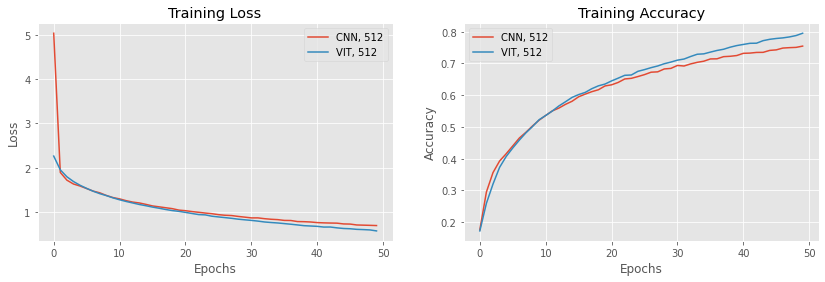

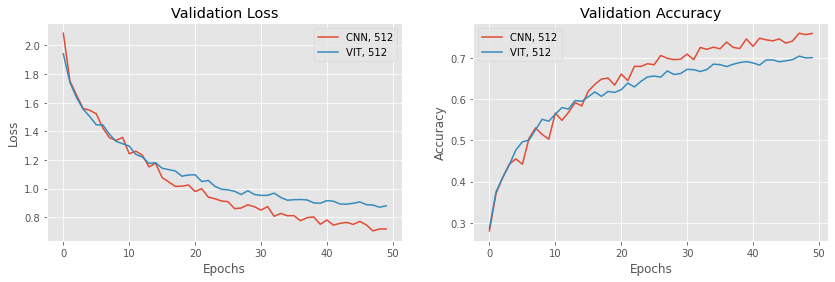

In [16]:
legends = ['CNN, 512', 'VIT, 512']
histories = [history_cnn_bs512, history_vit_bs512]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])